In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import dirichlet
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

# Density Estimation

## 1: GMM

In [156]:
#GMM datasets
def gen_data(seed,n):
    np.random.seed(seed)
    p = bernoulli.rvs(0.2,size = n)
    y = np.random.randn(n)
    y[p==0] +=-2
    y[p==1]+=2
    return y.reshape(-1,1)

#Generate data (change n for both plots)
#n = 50 
n = 200

seed = 102
n_test = 5000
d = 1
y = gen_data(seed,n)
mean_y = np.mean(y)
std_y = np.std(y)
y = (y-mean_y)/std_y
y_test = gen_data(seed+1,n_test).reshape(-1,1)
y_test = (y-mean_y)/std_y

y_plot = np.arange(-4,4,0.05).reshape(-1,1)*std_y + mean_y
dy = y_plot[1]-y_plot[0]
true_pdf = (0.8*norm.pdf(y_plot,loc = -2) + 0.2*norm.pdf(y_plot,loc = 2))

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


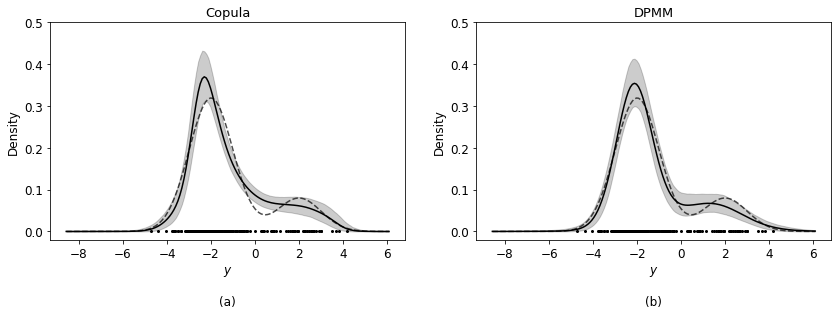

In [157]:
#load random densities
logpdf_pr = np.load('plot_files/copula_gmm_logpdf_pr_n{}.npy'.format(n))
logcdf_pr = np.load('plot_files/copula_gmm_logcdf_pr_n{}.npy'.format(n))

#Extract joint
pdf_pr = np.exp(logpdf_pr)[:,:,-1]
cdf_pr = np.exp(logcdf_pr)[:,:,-1]

#Compute mean and quantiles
mean_pdf_pr = np.mean(pdf_pr,axis = 0)
bot25_pdf_pr = np.percentile(pdf_pr,2.5,axis = 0)
top25_pdf_pr = np.percentile(pdf_pr,97.5,axis = 0)

#GMM ground truth comparison
f =plt.figure(figsize=(14,4))
ylim = (-0.02, 0.5)
#ylim = (-0.03988344073295537, 1.1)

plt.subplot(1,2,1)
plt.title('Copula',fontsize = 13)
sns.lineplot(y_plot[:,0],mean_pdf_pr/std_y,color = 'k')
plt.fill_between(y_plot[:,0], top25_pdf_pr/std_y,bot25_pdf_pr/std_y,alpha = 0.2, label = '95% CI',color ='k')
plt.plot(y_plot,true_pdf,color = 'k',linestyle = '--',alpha = 0.7, label = 'Truth')
plt.scatter(y*std_y + mean_y,np.zeros(n),color = "k",s =4,label = 'Data')
#plt.legend(loc = 1)
ylim = plt.ylim(ylim)
xlim = plt.xlim()
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$ \n \n(a)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)

plt.subplot(1,2,2)
gmm_plot = pd.read_csv("plot_files/dpmm_gmm_plot_n{}.csv".format(n))

mean_pdf_MCMC = gmm_plot['mean_pdf']
post_pdf_low_MCMC = gmm_plot['top25_pdf']
post_pdf_high_MCMC = gmm_plot['bot25_pdf']

plt.plot(y_plot,true_pdf,color = 'k',linestyle = '--',alpha = 0.7, label = 'Truth')
sns.lineplot(y_plot[:,0],mean_pdf_MCMC/std_y,label = 'Posterior mean',color = 'k')
plt.fill_between(y_plot[:,0], post_pdf_high_MCMC/std_y,post_pdf_low_MCMC/std_y,alpha = 0.2, label = '95% credible interval',color = 'k')
plt.scatter(y*std_y + mean_y,np.zeros(n),color = "k",s =4,label = 'Data')

#plt.legend(loc = 1)
plt.legend("",frameon=False)
plt.title('DPMM',fontsize = 13)
plt.ylim(ylim)
plt.xlim(xlim)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$ \n \n(b)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)

f.savefig("plots/gmm_example_{}.pdf".format(n),bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

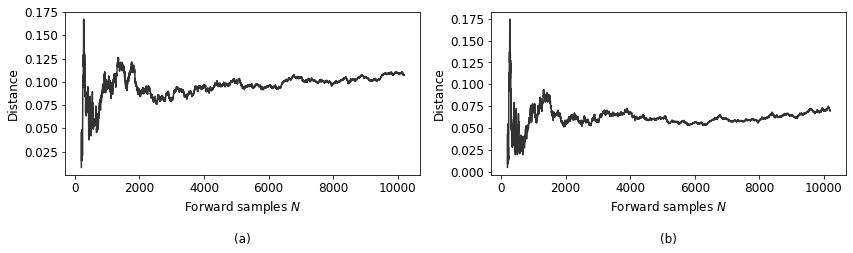

In [158]:
#Convergence plot

pdiff = np.load('plot_files/copula_gmm_pr_pdiff_n{}.npy'.format(n))
cdiff = np.load('plot_files/copula_gmm_pr_cdiff_n{}.npy'.format(n))

plt.figure()
f = plt.figure(figsize = (14,3))
plt.subplot(1,2,1)

dy = y_plot[1]- y_plot[0]
plt.plot(np.arange(10000)+n,pdiff[0,0:10000]*np.size(y_plot)*dy,color = 'black',alpha = 0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('Forward samples $N$ \n \n(a)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)

plt.subplot(1,2,2)
plt.plot(np.arange(10000)+n,cdiff[0,0:10000]*np.size(y_plot)*dy,color = 'black',alpha = 0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('Forward samples $N$ \n \n(b)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
f.savefig('plots/convergence_gmm_{}.pdf'.format(n), bbox_inches='tight')

## 1: Galaxy

In [159]:
#Load data and normalize
from pydataset import data
y_gal = data('galaxies').values
y_gal = y_gal /1000
n_gal = np.shape(y_gal)[0]

mean_y = np.mean(y_gal)
std_y = np.std(y_gal) 

n_plot = 200
y_plot_gal = np.linspace(5,40,n_plot)
dy = y_plot_gal[1]-y_plot_gal[0]

#Find bandwidth and fit KDE
kde_sm = KDEMultivariate(y_gal,var_type = 'c',bw = 'cv_ml')

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/statsmodels/nonparametric/kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


### Plots

In [160]:
##Load posterior samples
pdf_joints_pr = np.exp(np.load('plot_files/copula_galaxy_logpdf_pr.npy')[:,:,-1])
cdf_conditionals_pr = np.exp(np.load('plot_files/copula_galaxy_logcdf_pr.npy'))

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


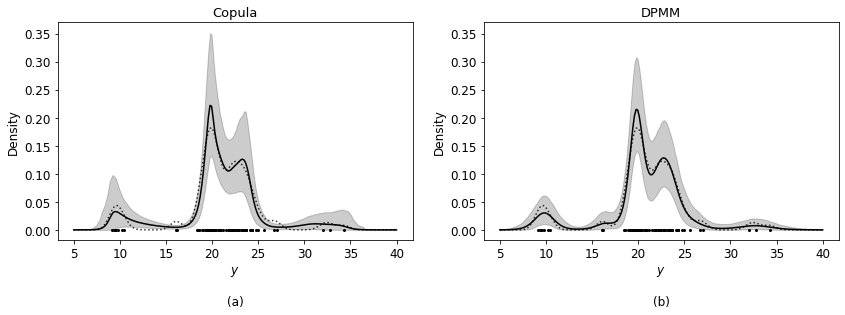

In [162]:
ylim = (-0.017714758231901252, 0.37)

f = plt.figure(figsize = (14,4 ))
plt.subplot(1,2,1)
#rescaled
mean_pdf = np.mean(pdf_joints_pr,axis = 0)
bot10_pdf = np.percentile(pdf_joints_pr,2.5,axis = 0)
top10_pdf = np.percentile(pdf_joints_pr,97.5,axis = 0)
sns.lineplot(y_plot_gal,mean_pdf/std_y,color = 'k')
plt.fill_between(y_plot_gal, top10_pdf/std_y,bot10_pdf/std_y,alpha = 0.2,color = 'k')

plt.plot(y_plot_gal,kde_sm.pdf(y_plot_gal),color = 'k',linestyle = ':',alpha = 0.8)
plt.scatter(y_gal,np.zeros(n_gal),color = "k",s =4,label = 'Data')
#plt.legend()
plt.title("Copula",fontsize = 13)

plt.ylim(ylim)
xlim = plt.xlim()

plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$\n \n(a)',fontsize = 12)
plt.ylabel('Density',fontsize=12)

#DPMM
plt.subplot(1,2,2)
galaxy_plot = pd.read_csv("plot_files/dpmm_galaxy_plot.csv")
mean_pdf = galaxy_plot['mean_pdf']
post_pdf_low = galaxy_plot['top25_pdf']
post_pdf_high = galaxy_plot['bot25_pdf']

plt.plot(y_plot_gal,kde_sm.pdf(y_plot_gal),color = 'k',linestyle = ':',alpha = 0.8,label = 'KDE')
sns.lineplot(y_plot_gal,mean_pdf,label = 'Posterior mean',color = 'k')
plt.fill_between(y_plot_gal, post_pdf_high,post_pdf_low,alpha = 0.2, label = '95% credible interval',color = 'k')
plt.scatter(y_gal,np.zeros(n_gal),color = "k",s =4,label = 'Data')
#plt.legend()

plt.ylim(ylim)
plt.xlim(xlim)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$\n \n(b)',fontsize = 12)
plt.ylabel('Density',fontsize=12)

plt.legend("",frameon=False)

plt.title("DPMM",fontsize = 13)
f.savefig('plots/copula_DPMM_galaxy.pdf', bbox_inches='tight')


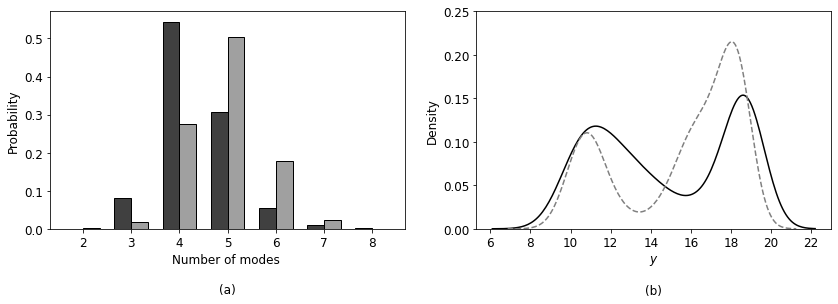

In [163]:
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
#Compute mode count for copula
B_postsamples = np.shape(pdf_joints_pr)[0]
modes_cop = np.zeros(B_postsamples,dtype = 'int')
for i in tqdm(range(B_postsamples)):
    modes_cop[i] = (np.diff(np.sign(np.diff(pdf_joints_pr[i])*dy)) < 0).sum() #look for when second derivative is negative

#compute mode count for dpmm
pdf_dpmm = pd.read_csv("plot_files/dpmm_galaxy_pdf_samples.csv").values[:,1:]
B_dpmm = np.shape(pdf_dpmm)[0]
modes_dpmm = np.zeros(B_dpmm,dtype = 'int')
for i in tqdm(range(B_dpmm)):
    modes_dpmm[i] = (np.diff(np.sign(np.diff(pdf_dpmm[i])*dy)) < 0).sum() #look for when second derivative is negative

#Setup plot
colors = ["k", "grey"]
modes_data = pd.concat([pd.DataFrame({'method': "Copula",'modes': modes_cop}),pd.DataFrame({'method': "DPMM",'modes':modes_dpmm})])
g = sns.histplot(modes_data,x = 'modes', hue = 'method',common_norm=False,\
                 multiple = 'dodge',discrete = True,stat = "probability",shrink = 0.7,palette = colors)
#g.legend_.set_title(None)
plt.legend("",frameon=False)
plt.xlabel('Number of modes \n \n(a)',fontsize = 12)
plt.ylabel('Probability',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)

#Quantiles 
plt.subplot(1,2,2)

m =10

#DPMM
cdf_dpmm = pd.read_csv("plot_files/dpmm_galaxy_cdf_samples.csv").values[:,1:]
B = np.shape(cdf_dpmm)[0]
quantiles_dpmm = np.zeros(B)
for i in range(B):
    quantiles_dpmm[i]= y_plot_gal[np.argmin(np.abs(cdf_dpmm[i] - m/100))]

#Copula
B = np.shape(cdf_conditionals_pr)[0]
quantiles_cop = np.zeros(B)
for i in range(B):
    quantiles_cop[i]= y_plot_gal[np.argmin(np.abs(cdf_conditionals_pr[i,:,0] - m/100))]
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlabel('$y$ \n \n(b)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
sns.kdeplot(quantiles_cop,label = 'Copula'.format(m),color = 'k',ls = '-')
sns.kdeplot(quantiles_dpmm,label = 'DPMM'.format(m),color = 'grey',ls = '--')

#plt.legend(loc = 1)
plt.legend("",frameon=False)

plt.ylim(0,0.25)

f.savefig('plots/modes_galaxy.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

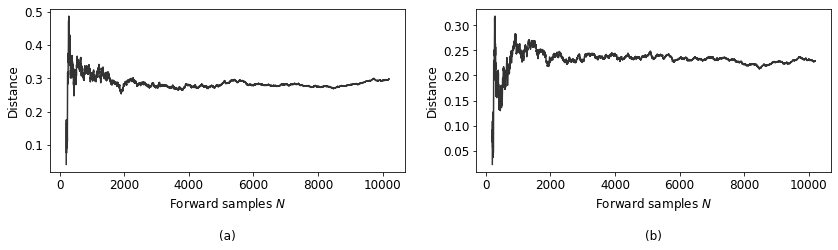

In [164]:
#Convergence plot

pdiff = np.load('plot_files/copula_galaxy_pr_pdiff.npy'.format(n))
cdiff = np.load('plot_files/copula_galaxy_pr_cdiff.npy'.format(n))

plt.figure()
f = plt.figure(figsize = (14,3))
plt.subplot(1,2,1)

dy = y_plot[1]- y_plot[0]
#normalize by pdf to get correct weighting?
plt.plot(np.arange(10000)+n,pdiff[0,0:10000]*np.size(y_plot)*dy,color = 'black',alpha = 0.8)
plt.xlabel('Forward samples $N$ \n \n(a)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,2)
plt.plot(np.arange(10000)+n,cdiff[0,0:10000]*np.size(y_plot)*dy,color = 'black',alpha = 0.8)
plt.xlabel('Forward samples $N$ \n \n(b)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
f.savefig('plots/convergence_galaxy.pdf', bbox_inches='tight')


## 2: Ozone

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


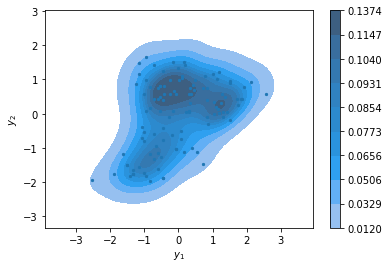

In [165]:
#Ozone
from matplotlib import cm

#load function
def load_ozone(n_plot_marg):
    from pydataset import data
    data = data('airquality')
    var = ['Ozone','Solar.R']
    y = data[var].dropna().values
    y[:,0] = y[:,0]**(1/3)
    y = (y-np.mean(y,axis =0))/np.std(y,axis = 0)
    n = np.shape(y)[0]
    d = np.shape(y)[1]

    ylim = (-2.5,2.25)
    xlim = (-2.75,2.75)

    y_plot_marg = np.zeros((n_plot_marg,d))
    y_plot_marg[:,0] = np.linspace(-2.75,2.75,num = n_plot_marg)
    y_plot_marg[:,1] = np.linspace(-2.5,2.25,num = n_plot_marg)

    dy1 = y_plot_marg[1,0]- y_plot_marg[0,0]
    dy2 = y_plot_marg[1,1]- y_plot_marg[0,1]

    y_plot_grid = np.meshgrid(y_plot_marg[:,0],y_plot_marg[:,1])
    y_plot = np.vstack((y_plot_grid[0].ravel(), y_plot_grid[1].ravel())).transpose()
    n_plot_y = np.shape(y_plot)[0]
    return y,y_plot,y_plot_grid,n,d,ylim,xlim,y_plot_marg

n_plot_marg = 25
y,y_plot,y_plot_grid,n,d,ylim,xlim,y_plot_marg =load_ozone(n_plot_marg)

sns.kdeplot(y[:,0],y[:,1],cbar = True,shade = True)
plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.scatter(y[:,0], y[:,1],s = 5)

d = np.shape(y)[1]

### Copula

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


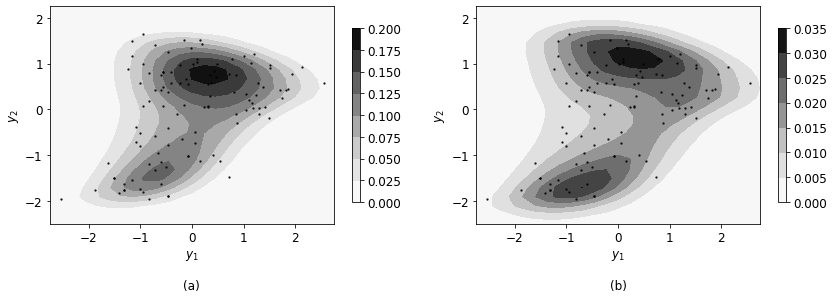

In [166]:
logpdf_pr = np.load('plot_files/copula_ozone_logpdf_pr.npy')
logcdf_pr = np.load('plot_files/copula_ozone_logcdf_pr.npy')

#Extract joint
pdf_pr = np.exp(logpdf_pr)[:,:,-1]
cdf_pr = np.exp(logcdf_pr)[:,:,-1]

pdf_pr_mean = np.mean(pdf_pr,axis = 0)
pdf_pr_std = np.std(pdf_pr,axis = 0)

fig = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
ax = fig.gca()
cont = ax.contourf(y_plot_grid[0], y_plot_grid[1],pdf_pr_mean.reshape\
                   (n_plot_marg,n_plot_marg),cmap=cm.Greys)
CB = fig.colorbar(cont, shrink=0.8, extend='both')
CB.ax.tick_params(labelsize=12)
plt.scatter(y[:,0], y[:,1],s =2,color = 'black',alpha = 0.7,label= 'Data')
plt.ylim(ylim)
plt.xlim(xlim)
plt.xlabel('$y_1$\n \n(a)',fontsize = 12)
plt.ylabel('$y_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.legend()

plt.subplot(1,2,2)
ax = fig.gca()
cont = ax.contourf(y_plot_grid[0], y_plot_grid[1], pdf_pr_std.reshape\
                   (n_plot_marg,n_plot_marg),cmap=cm.Greys)
CB = fig.colorbar(cont, shrink=0.8, extend='both')
CB.ax.tick_params(labelsize=12)
plt.xlabel('$y_1$\n \n(b)',fontsize = 12)
plt.ylabel('$y_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.scatter(y[:,0], y[:,1],s =2,color = 'black',alpha = 0.7,label= 'Data')
plt.show()
fig.savefig('plots/mv_copula_ozone.pdf', bbox_inches='tight')

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


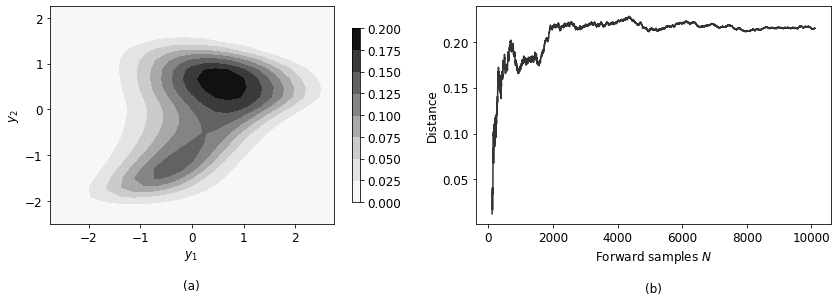

In [170]:
#Convergence plots
pdiff = np.load('plot_files/copula_ozone_pr_pdiff.npy'.format(n))
cdiff = np.load('plot_files/copula_ozone_pr_cdiff.npy'.format(n))
pdf_pr_conv = np.load('plot_files/copula_ozone_pr_pdf_samp.npy')
T_fwdsamples = np.shape(pdiff)[1]

f = plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
ax = f.gca()
cont = ax.contourf(y_plot_grid[0], y_plot_grid[1],pdf_pr_conv.reshape\
                   (n_plot_marg,n_plot_marg),cmap=cm.Greys)
CB = f.colorbar(cont, shrink=0.8, extend='both')
CB.ax.tick_params(labelsize=12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.xlabel('$y_1$ \n \n(a)',fontsize = 12)
plt.ylabel('$y_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,2)

#normalize by pdf to get correct weighting?
dy1 = np.abs(y_plot_grid[0][0,1] - y_plot_grid[0][0,0])
dy2 = np.abs(y_plot_grid[1][1,0] - y_plot_grid[1][0,0])
plt.plot(np.arange(T_fwdsamples)+n,pdiff[0]*(n_plot_marg**2*dy1*dy2),color = 'black',alpha = 0.8)
plt.xlabel('Forward samples $N$ \n \n(b)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
f.savefig('plots/convergence_ozone.pdf', bbox_inches='tight')


### DPMM with MCMC

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


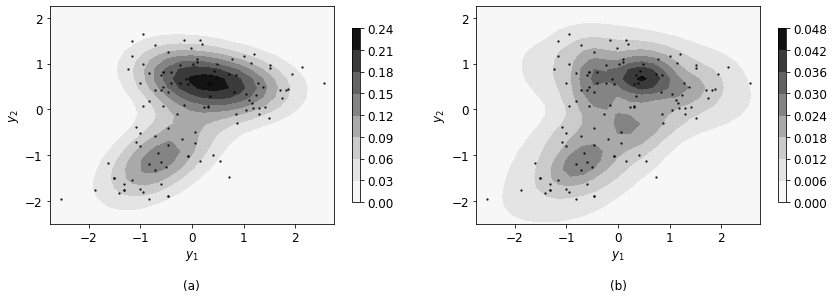

In [171]:
from matplotlib import cm
import matplotlib.colors as mc


#Load in R data
ozone_plot = pd.read_csv("plot_files/dpmm_ozone_plot.csv")
y_plot = ozone_plot.iloc[:,1:3].values
n_plot_marg = 25
mean_pdf = ozone_plot["mean_pdf"].values
std_pdf = ozone_plot["std_pdf"].values
bot25_pdf = ozone_plot["bot25_pdf"].values
top25_pdf = ozone_plot["top25_pdf"].values


fig = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
ax = fig.gca()
cont = ax.contourf(y_plot[:,0].reshape(n_plot_marg,n_plot_marg), y_plot[:,1].reshape(n_plot_marg,n_plot_marg), mean_pdf.reshape(n_plot_marg,n_plot_marg),cmap=cm.Greys)
CB = fig.colorbar(cont, shrink=0.8, extend='both')
CB.ax.tick_params(labelsize=12)
plt.xlabel('$y_1$\n \n(a)',fontsize = 12)
plt.ylabel('$y_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.title(r'DPMM posterior mean density')
plt.scatter(y[:,0], y[:,1],s =2,color = 'black',alpha = 0.7,label= 'Data')
#plt.legend()

plt.subplot(1,2,2)
#plt.title('DPMM posterior standard deviation of density')
ax = fig.gca()
cont = ax.contourf(y_plot[:,0].reshape(n_plot_marg,n_plot_marg), y_plot[:,1].reshape(n_plot_marg,n_plot_marg), \
                   std_pdf.reshape(n_plot_marg,n_plot_marg),cmap=cm.Greys)
CB = fig.colorbar(cont, shrink=0.8, extend='min')
CB.ax.tick_params(labelsize=12)
plt.xlabel('$y_1$\n \n(b)',fontsize = 12)
plt.ylabel('$y_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.scatter(y[:,0], y[:,1],s =2,color = 'black',alpha = 0.7,label= 'Data')

fig.savefig('plots/mv_dpmm_fullcov_ozone.pdf', bbox_inches='tight')

## 3: UCI Datasets

In [2]:
#Pick dataset
for dataset in ["Breast","Ionosphere","Parkinsons","Wine"]:
    #Load test log likelihoods
    test_loglik_cop = np.load('plot_files/copula_mv_loglik{}.npy'.format(dataset))
    test_loglik_kde = np.load('plot_files/kde_mv_loglik{}.npy'.format(dataset))
    test_loglik_dpmm = np.load('plot_files/dpmm_mv_loglik{}.npy'.format(dataset))
    test_loglik_gaussian= np.load('plot_files/gaussian_mv_loglik{}.npy'.format(dataset))

    #Print average
    print('Dataset: {}'.format(dataset))
    print('Avg test loglik for Gaussian = {} +- {}'.format(np.mean(test_loglik_gaussian),np.std(test_loglik_gaussian)/np.sqrt(10)))
    print('Avg test loglik for KDE = {} +- {}'.format(np.mean(test_loglik_kde),np.std(test_loglik_kde)/np.sqrt(10)))
    print('Avg test loglik for DPMM = {} +- {}'.format(np.mean(test_loglik_dpmm), np.std(test_loglik_dpmm)/np.sqrt(10)))
    print('Avg test loglik for Copula = {} +- {} \n'.format(np.mean(test_loglik_cop), np.std(test_loglik_cop)/np.sqrt(10)))

Dataset: Breast
Avg test loglik for Gaussian = -17.849491691589357 +- 0.611488516184744
Avg test loglik for KDE = -25.619919204711913 +- 0.29051801448479386
Avg test loglik for DPMM = -33.36565228037527 +- 0.7965586774984481
Avg test loglik for Copula = -13.006437683105469 +- 0.2637698038026071 

Dataset: Ionosphere
Avg test loglik for Gaussian = -49.4036678314209 +- 1.9667628409767892
Avg test loglik for KDE = -32.256393623352054 +- 0.7891771197137177
Avg test loglik for DPMM = -36.47834234976691 +- 0.5904821388333221
Avg test loglik for Copula = -21.496849632263185 +- 1.6254192908161167 

Dataset: Parkinsons
Avg test loglik for Gaussian = -14.30153455734253 +- 0.5401944529766539
Avg test loglik for KDE = -15.557090950012206 +- 0.40939450833595564
Avg test loglik for DPMM = -25.747826335085268 +- 0.9243655166033025
Avg test loglik for Copula = -9.865077781677247 +- 0.27628095586001306 

Dataset: Wine
Avg test loglik for Gaussian = -16.08654193878174 +- 0.25985498445110816
Avg test log

### Performance with d

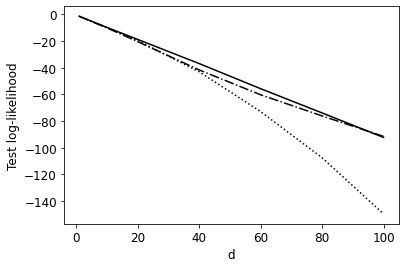

In [124]:
#Load test loglik
test_loglik_cop = np.load('plot_files/copula_mv_loglik{}.npy'.format("gmm"))
test_loglik_kde = np.load('plot_files/kde_mv_loglik{}.npy'.format("gmm"))
test_loglik_dpmm = np.load('plot_files/dpmm_mv_loglik{}.npy'.format("gmm"))


d_range = np.array([1,2,10,20,40,60,80,100])
f =plt.figure(figsize=(6,4))

plt.plot(d_range,test_loglik_cop,linestyle = '-',label = 'Copula',color = 'k')
plt.plot(d_range,test_loglik_dpmm,linestyle = ':',label = 'DPMM (VI)',color = 'k')
plt.plot(d_range,test_loglik_kde,linestyle= '-.',label = 'KDE',color = 'k')
plt.xlabel('d',fontsize = 12)
plt.ylabel('Test log-likelihood',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.title('GMM with dimensionality')
#plt.legend()
f.savefig('plots/highd_GMM.pdf', bbox_inches='tight')


# Regression

## 4: Lidar 

### Joint Method

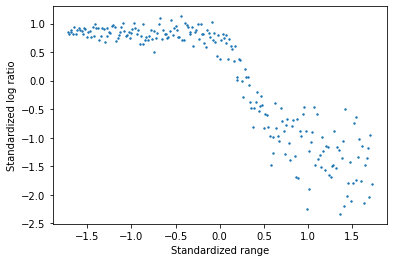

In [173]:
#Lidar data
DATA_URI = 'http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat'

df = pd.read_csv(DATA_URI,delim_whitespace = True)
y = df['logratio'].values
x = df['range'].values.reshape(-1,1)

y =(y-np.mean(y))/np.std(y)
x = (x - np.mean(x,axis = 0))/np.std(x,axis = 0)
plt.scatter(x,y, s= 2)
plt.xlabel('Standardized range')
plt.ylabel('Standardized log ratio')

y_plot = np.linspace(-3.0,2.0,num = 200)
n_plot_y = np.shape(y_plot)[0]
dy = y_plot[1] - y_plot[0]

x_plot = np.linspace(np.min(x),np.max(x),num = 40)
n_plot_x = np.shape(x_plot)[0]
dx = x_plot[1] - x_plot[0]

n = np.shape(y)[0]
n_plot_marg = np.array([np.shape(x_plot)[0],np.shape(y_plot)[0]])

xlim = (-1.8,1.8)
ylim = (-2.5,1.7)

z_plot_grid = np.meshgrid(x_plot,y_plot)
x_plot_ravel = z_plot_grid[0].ravel().reshape(-1,1)
y_plot_ravel = z_plot_grid[1].ravel()


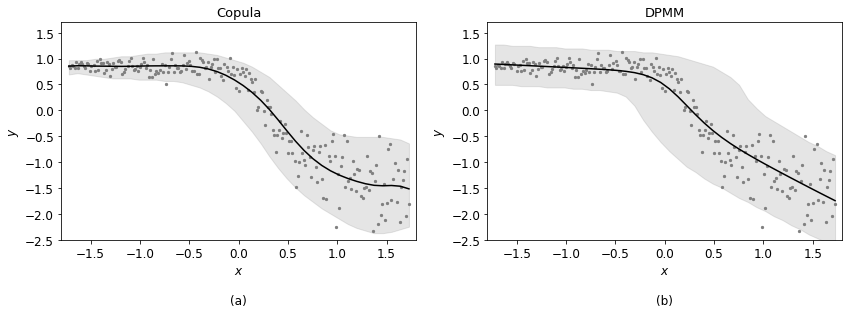

In [174]:
#Load predictive densities
pdf_cop_condj = np.load('plot_files/jcopula_lidar_pdf_plot.npy')
cdf_cop_condj = np.load('plot_files/jcopula_lidar_cdf_plot.npy')


#preprocess
cdf_condj_plot = cdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condj_plot = pdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])

n_plot_x = np.shape(x_plot)[0]

bot25_joint = np.zeros(n_plot_x)
top25_joint = np.zeros(n_plot_x)
mean_cop_joint = np.zeros(n_plot_x)

for j in range(n_plot_x):
    bot25_joint[j] =y_plot[np.searchsorted(cdf_condj_plot[:,j],0.025)-1]
    top25_joint[j] =y_plot[np.searchsorted(cdf_condj_plot[:,j],0.975)-1]
    mean_cop_joint[j] = np.sum(pdf_condj_plot[:,j]*y_plot*dy)

    
#plot
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
plt.plot(x_plot,mean_cop_joint,color = 'k',label = 'Posterior mean')
plt.fill_between(x_plot, bot25_joint, top25_joint, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(a)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Copula',fontsize = 13)
#plt.legend(loc = 3)

plt.subplot(1,2,2)
lidar_plot_xrange =  pd.read_csv("plot_files/dpmm_lidar_plot_xrange.csv")

plt.title('DPMM',fontsize = 13)
plt.plot(x_plot,lidar_plot_xrange["mean"],label = 'Posterior mean',color = 'k')
plt.fill_between(x_plot, lidar_plot_xrange["top25"], lidar_plot_xrange["bot25"], alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(b)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
f.savefig('plots/lidar_copula_jdpmm.pdf', bbox_inches='tight')


/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


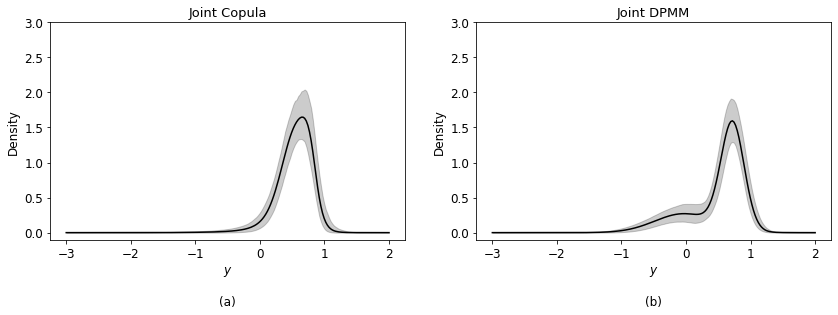

In [177]:
#pick x
#x_pr = [-3]
x_pr = [0] 
ylim2 = (-0.102216080353868, 3.0)

#Load samples and process
logpdf_joints_pr = np.load('plot_files/jcopula_lidar_logpdf_pr{}.npy'.format(x_pr[0]))
pdf_condj_pr = np.exp(logpdf_joints_pr[:,:,-1]  - logpdf_joints_pr[:,:,-2])
mean_pdf_condj = np.mean(pdf_condj_pr,axis = 0)
bot25_pdf_condj = np.percentile(pdf_condj_pr,2.5,axis = 0)
top25_pdf_condj =  np.percentile(pdf_condj_pr,97.5,axis = 0)



f = plt.figure(figsize = (14,4 ))
plt.subplot(1,2,1)
#rescaled
sns.lineplot(y_plot,mean_pdf_condj,color = 'k',label = 'Posterior mean')
plt.fill_between(y_plot, top25_pdf_condj,bot25_pdf_condj,alpha = 0.2,color = 'k',label = '95% credible interval')
    
plt.xlabel('$y$ \n \n(a)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
#plt.legend(loc = 2)
plt.title("Joint Copula".format(x_pr[0]),fontsize = 13)
plt.ylim(ylim2)
xlim2 = plt.xlim()
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.legend(loc = 2)
plt.legend("",frameon=False)

#plot 
plt.subplot(1,2,2)
lidar_plot = pd.read_csv("plot_files/dpmm_lidar_plot{}.csv".format(x_pr[0]))
#rescaled
sns.lineplot(y_plot,lidar_plot['mean_pdf'],color = 'k')
plt.fill_between(y_plot, lidar_plot['top25_pdf'],lidar_plot['bot25_pdf'],alpha = 0.2,color = 'k',label = '95% credible interval')
    
plt.xlabel('$y$ \n \n(b)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
plt.title("Joint DPMM".format(x_pr[0]),fontsize = 13)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim2)
plt.xlim(xlim2)

f.savefig(f"plots/lidar_jdpmm_x{x_pr[0]}.pdf", bbox_inches='tight')


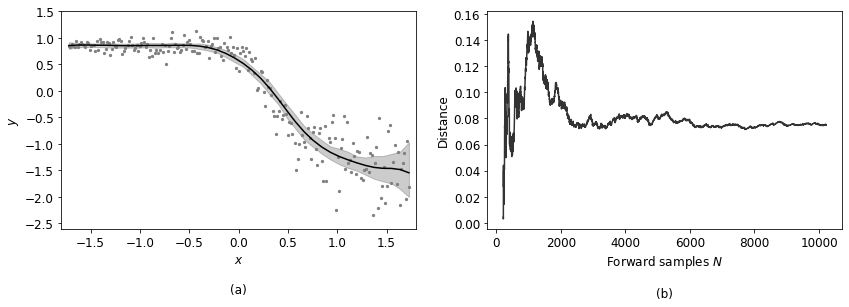

In [178]:
#Load samples
cdf_condj_pr = np.load("plot_files/jcopula_lidar_cdf_median.npy") #Took 13 seconds for 40 x 40.

#Setup plot
n_grid_x = np.shape(x_plot)[0]
n_grid_y = 40
y_plot_median = np.linspace(bot25_joint,top25_joint,n_grid_y,axis = -1)
xlim = (-1.8,1.8)
ylim = (-2.6,1.5)

cdf_condj_pr = cdf_condj_pr.reshape(B_postsamples,n_grid_x,n_grid_y)
median_samp = np.zeros((B_postsamples,n_grid_x))
for j in range(n_grid_x):
    median_samp[:,j] = y_plot_median[j,np.argmin(np.abs(cdf_condj_pr[:,j]- 0.5),axis = 1)]

f = plt.figure(figsize = (14,4))

mean_median_pr = np.mean(median_samp,axis = 0)
bot25_median_pr = np.percentile(median_samp,2.5,axis = 0)
top25_median_pr = np.percentile(median_samp,97.5,axis = 0)

plt.subplot(1,2,1)
plt.plot(x_plot,mean_median_pr,color = 'k',label = 'Posterior mean')
plt.fill_between(x_plot, top25_median_pr,bot25_median_pr,alpha = 0.2, label = '95% credible interval',color = 'k')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(a)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
#plt.title('Joint copula median of $P_\infty(y \mid x)$')
#plt.legend(loc = 3)

plt.subplot(1,2,2)
#x_pr = [-3]
x_pr = [0] 
pdiff = np.load("plot_files/jcopula_lidar_pr_pdiff{}.npy".format(x_pr[0]))
dy = y_plot[1]- y_plot[0]
#normalize by pdf to get correct weighting?
plt.plot(np.arange(10000)+n,pdiff[0,0:10000]*np.size(y_plot)*dy,color = 'black',alpha = 0.8)
plt.xlabel('Forward samples $N$\n \n(b)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.title('$L_1$-distance between $p_N$ and initial $p_n$ at $x = {}$'.format(x_pr[0]))
f.savefig('plots/lidar_median_convergence.pdf', bbox_inches='tight')


### Conditional Method

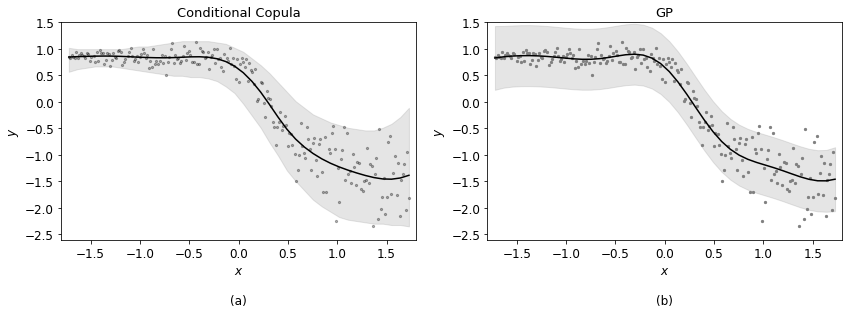

In [179]:
#Load samples
#Load predictive densities
pdf_cop_condc = np.load('plot_files/ccopula_lidar_pdf_plot.npy')
cdf_cop_condc = np.load('plot_files/ccopula_lidar_cdf_plot.npy')

cdf_condc_plot = cdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condc_plot = pdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])

n_plot_x = np.shape(x_plot)[0]

bot25_cond = np.zeros(n_plot_x)
top25_cond = np.zeros(n_plot_x)
mean_cop_cond = np.zeros(n_plot_x)

for j in range(n_plot_x):
    bot25_cond[j] =y_plot[np.searchsorted(cdf_condc_plot[:,j],0.025)-1]
    top25_cond[j] =y_plot[np.searchsorted(cdf_condc_plot[:,j],0.975)-1]
    mean_cop_cond[j] = np.sum(pdf_condc_plot[:,j]*y_plot*dy)

xlim = (-1.8,1.8)
ylim = (-2.6,1.5)
    
#plot
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
plt.plot(x_plot,mean_cop_cond,color = 'k',label = 'Mean')
plt.fill_between(x_plot, bot25_cond, top25_cond, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'k',alpha = 0.3)
plt.xlabel('$x$\n \n(a)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Conditional Copula',fontsize = 13)


plt.subplot(1,2,2)
mean_gp = np.load('plot_files/gp_lidar_mean.npy')
std_gp = np.load('plot_files/gp_lidar_std.npy')

plt.title('GP',fontsize = 13)
plt.plot(x_plot,mean_gp,label = 'Predictive mean',color = 'k')
plt.fill_between(x_plot, mean_gp + 2*std_gp, mean_gp - 2*std_gp, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(b)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.legend(loc = 3)
plt.ylim(ylim)
plt.xlim(xlim)


f.savefig('plots/lidar_conditcopula_gp.pdf', bbox_inches='tight')

/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


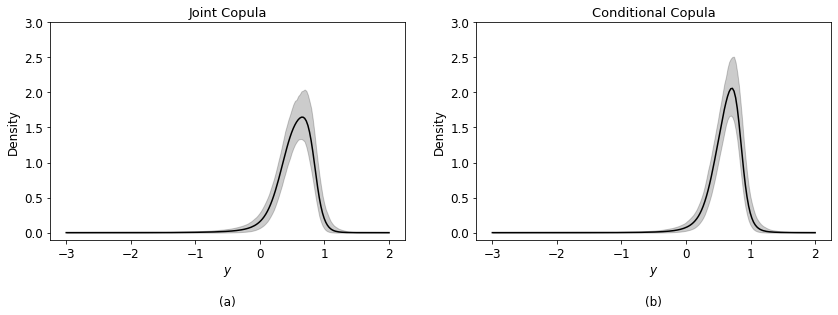

In [181]:
#x_pr = [-3]
x_pr = [0] 
ylim2 = (-0.102216080353868, 3.0)

f = plt.figure(figsize = (14,4 ))
plt.subplot(1,2,1)

#Load samples and Process
logpdf_joints_pr = np.load('plot_files/jcopula_lidar_logpdf_pr{}.npy'.format(x_pr[0]))
pdf_condj_pr = np.exp(logpdf_joints_pr[:,:,-1]  - logpdf_joints_pr[:,:,-2])
mean_pdf_condj = np.mean(pdf_condj_pr,axis = 0)
bot25_pdf_condj = np.percentile(pdf_condj_pr,2.5,axis = 0)
top25_pdf_condj =  np.percentile(pdf_condj_pr,97.5,axis = 0)

#rescaled
sns.lineplot(y_plot,mean_pdf_condj,color = 'k',label = 'Posterior mean')
plt.fill_between(y_plot, top25_pdf_condj,bot25_pdf_condj,alpha = 0.2,color = 'k',label = '95% credible interval')
    
plt.xlabel('$y$\n \n(a)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.title("Joint Copula".format(x_pr[0]),fontsize = 13)
plt.ylim(ylim2)
xlim2 = plt.xlim()
#plt.legend(loc = 2)
plt.legend("",frameon=False)


#plot 
plt.subplot(1,2,2)

#Load samples and process
logpdf_pr = np.load('plot_files/ccopula_lidar_logpdf_pr{}.npy'.format(x_pr[0]))
pdf_condc_pr = np.exp(logpdf_pr[:,:,0])
mean_pdf_condc = np.mean(pdf_condc_pr,axis = 0)
bot25_pdf_condc = np.percentile(pdf_condc_pr,2.5,axis = 0)
top25_pdf_condc =  np.percentile(pdf_condc_pr,97.5,axis = 0)

#rescaled
sns.lineplot(y_plot,mean_pdf_condc,color = 'k')
plt.fill_between(y_plot, top25_pdf_condc,bot25_pdf_condc,alpha = 0.2,color = 'k',label = '95% credible interval')
    
plt.xlabel('$y$\n \n(b)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.legend(loc = 2)
plt.title("Conditional Copula".format(x_pr[0]),fontsize = 13)

plt.ylim(ylim2)
plt.xlim(xlim2)



f.savefig(f"plots/lidar_jc_x{x_pr[0]}.pdf", bbox_inches='tight')


## 5: Moon

In [182]:
from sklearn.datasets import make_moons

seed = 52
n = 100
n_test = 5000
noise = 0.3
x_temp,y_temp= make_moons(n+n_test,noise = noise,random_state = seed)
y = y_temp[0:n]
x = x_temp[0:n]
y_test = y_temp[n:n+n_test]
x_test = x_temp[n:n+n_test]

d = np.shape(x)[1]
d_gp = d

#normalize
mean_norm = np.mean(x,axis = 0)
std_norm = np.std(x,axis = 0)
x = (x - mean_norm)/std_norm
x_test = (x_test - mean_norm)/std_norm

#for plot
noise = 0
x_temp,y_temp= make_moons(n+n_test,noise = noise,random_state = seed)
y_test2 = y_temp[n:n+n_test]
x_test2 = x_temp[n:n+n_test]

types = np.array([0.,0.])
n_cats = np.array([])

#normalize
x_test2 = (x_test2 - np.mean(x_test2,axis = 0))/np.std(x_test2,axis = 0)

#Setup plot
y_plot = np.array([0])
x_plot = np.linspace(-4,4.1,25)
x_meshgrid = np.meshgrid(x_plot,x_plot)
n_grid1 = np.shape(x_meshgrid)[1]
n_grid2 = np.shape(x_meshgrid)[2]

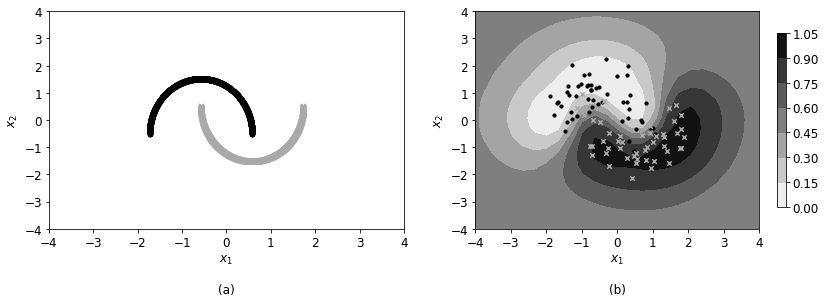

In [183]:
fig = plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
xlim = (-4,4)
ylim = (-4,4)
plt.xlim(xlim)
plt.ylim(ylim)
#test data
pos_ind = y_test==1
neg_ind = y_test==0
plt.xlabel('$x_1$ \n \n(a)',fontsize = 12)
plt.ylabel(r'$x_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.scatter(x_test2[neg_ind,0],x_test2[neg_ind,1],label = r'$y=0$',s = 20, color = 'k',marker = 'o')
plt.scatter(x_test2[pos_ind,0],x_test2[pos_ind,1],label = r'$y=1$',s =20, color = 'darkgrey',marker = 'x')
#plt.legend()


plt.subplot(1,2,2)
gp_pred = np.load('plot_files/gp_moon_pred.npy')[:,1].reshape(np.size(x_plot),np.size(x_plot))

ax = fig.gca()
n_grid1 = np.shape(x_meshgrid)[1]
n_grid2 = np.shape(x_meshgrid)[2]
cont = ax.contourf(x_meshgrid[0], x_meshgrid[1], gp_pred,cmap = 'binary')
CB = fig.colorbar(cont, shrink=0.8)
CB.ax.tick_params(labelsize=12)
plt.xlim(xlim)
plt.ylim(ylim)
pos_ind = y==1
neg_ind = y==0
plt.xlabel('$x_1$ \n \n(b)',fontsize = 12)
plt.ylabel(r'$x_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.scatter(x[neg_ind,0],x[neg_ind,1],label = r'$y=0$',s = 10, color = 'k',marker = 'o')
plt.scatter(x[pos_ind,0],x[pos_ind,1],label = r'$y=1$',s =20, color = 'darkgrey',marker = 'x')
#plt.legend()
fig.savefig("plots/moon_data.pdf", bbox_inches='tight')

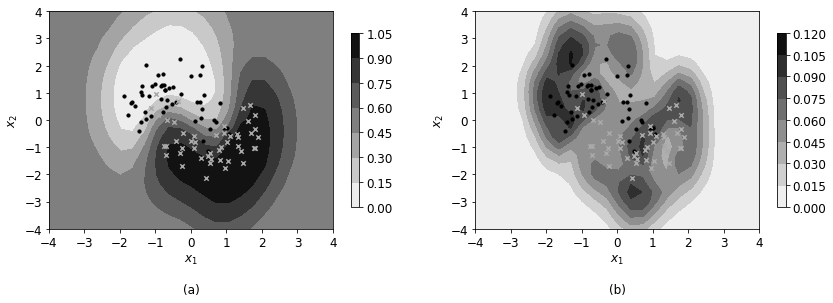

In [184]:
#Load samples
pmf_ytest_samp = np.exp(np.load("plot_files/ccopula_moon_logpmf_ytest_pr.npy"))
mean_pmf = np.mean(pmf_ytest_samp,axis = 0).reshape(np.shape(x_meshgrid[0])[0],np.shape(x_meshgrid[1])[0])
std_pmf = np.std(pmf_ytest_samp,axis = 0).reshape(np.shape(x_meshgrid[0])[0],np.shape(x_meshgrid[1])[0])

fig = plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
ax = fig.gca()
cont = ax.contourf(x_meshgrid[0], x_meshgrid[1], mean_pmf.reshape(np.shape(x_meshgrid[0])[0],np.shape(x_meshgrid[1])[0]),cmap = 'binary')
CB = fig.colorbar(cont, shrink=0.8)
CB.ax.tick_params(labelsize=12)
plt.xlabel('$x_1$\n \n(a)',fontsize = 12)
plt.ylabel(r'$x_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(x[neg_ind,0],x[neg_ind,1],label = r'$y=0$',s = 10, color = 'k',marker = 'o')
plt.scatter(x[pos_ind,0],x[pos_ind,1],label = r'$y=1$',s =20, color = 'darkgrey',marker = 'x')
#plt.legend()

plt.subplot(1,2,2)
ax = fig.gca()
cont = ax.contourf(x_meshgrid[0], x_meshgrid[1], std_pmf.reshape(np.shape(x_meshgrid[0])[0],np.shape(x_meshgrid[1])[0]),cmap = 'binary')
CB = fig.colorbar(cont, shrink=0.8)
CB.ax.tick_params(labelsize=12)
plt.xlabel('$x_1$ \n \n(b)',fontsize = 12)
plt.ylabel(r'$x_2$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.xlim(xlim)
plt.ylim(ylim)
plt.scatter(x[neg_ind,0],x[neg_ind,1],label = r'$y=0$',s = 10, color = 'k',marker = 'o')
plt.scatter(x[pos_ind,0],x[pos_ind,1],label = r'$y=1$',s =20, color = 'darkgrey',marker = 'x')

fig.savefig("plots/moon_fit.pdf", bbox_inches='tight')

[ 1.00146161 -0.79941383]


/Users/efong/virtualenvs/PR/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

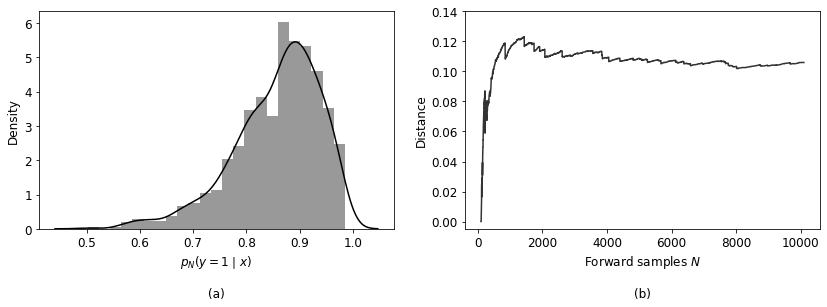

In [185]:
#Load sample and pdiff
pmf_yn_samp = np.exp(np.load('plot_files/ccopula_moon_logpmf_yn_pr.npy'))
pdiff = np.load('plot_files/ccopula_moon_pdiff.npy')
T = 10000

plt.figure()
f = plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
ax = f.gca()
i = 30
print(x[i])
sns.distplot(pmf_yn_samp[:,i,0],color = 'k')
plt.xlabel('$p_N(y=1 \mid x)$ \n \n(a)',fontsize = 12)
plt.ylabel('Density',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,2)
plt.plot(np.arange(n,n+T),pdiff[0,n:,i],color = 'black',alpha = 0.8)
plt.xlabel('Forward samples $N$\n \n(b)',fontsize = 12)
plt.ylabel('Distance',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim((-0.004801830649375916, 0.14))
f.savefig('plots/convergence_moon.pdf', bbox_inches='tight')


## 6: UCI Datasets

### Regression

In [4]:
#Output Test loglik
for dataset in ["Boston","Concrete","Diabetes","Wine"]:

    #Load test log likelihoods
    test_loglik_cop = np.load('plot_files/copula_regression_loglik{}.npy'.format(dataset))
    test_loglik_bayeslin = np.load('plot_files/bayeslin_regression_loglik{}.npy'.format(dataset))
    test_loglik_gp= np.load('plot_files/gp_regression_loglik{}.npy'.format(dataset))

    #Print average
    print('Dataset: {}'.format(dataset))
    print('Avg test loglik for Bayes Linear = {} +- {}'.format(np.mean(test_loglik_bayeslin),np.std(test_loglik_bayeslin)/np.sqrt(10)))
    print('Avg test loglik for GP = {} +- {}'.format(np.mean(test_loglik_gp),np.std(test_loglik_gp)/np.sqrt(10)))
    print('Avg test loglik for Copula = {} +- {}\n'.format(np.mean(test_loglik_cop),np.std(test_loglik_cop)/np.sqrt(10)))

Dataset: Boston
Avg test loglik for Bayes Linear = -0.841900422520513 +- 0.04300086697059703
Avg test loglik for GP = -0.4038145623304225 +- 0.039605819801467344
Avg test loglik for Copula = -0.35145519822835924 +- 0.024704918804777293

Dataset: Concrete
Avg test loglik for Bayes Linear = -0.9647636645753161 +- 0.008448228588095115
Avg test loglik for GP = -0.36410616678416863 +- 0.014127462651501976
Avg test loglik for Copula = -0.44537952840328215 +- 0.01282871447971992

Dataset: Diabetes
Avg test loglik for Bayes Linear = -1.09637495705841 +- 0.01661655236475689
Avg test loglik for GP = -1.0892978774152946 +- 0.014711543274188697
Avg test loglik for Copula = -1.0031625151634216 +- 0.017576509517613813

Dataset: Wine
Avg test loglik for Bayes Linear = -1.1955032431502202 +- 0.016594449764570352
Avg test loglik for GP = -0.4966581186732145 +- 0.03391883936667925
Avg test loglik for Copula = -1.1428149580955504 +- 0.020135234798719606



### Classification

In [3]:
#Output Test loglik
for dataset in ["Breast","Ionosphere","Parkinsons","Statlog"]:
    #Load test log likelihoods
    test_loglik_cop = np.load('plot_files/copula_classification_loglik{}.npy'.format(dataset))
    test_loglik_logistic = np.load('plot_files/logistic_classification_loglik{}.npy'.format(dataset))
    test_loglik_gp = np.load('plot_files/gp_classification_loglik{}.npy'.format(dataset))

    #Print average
    print('Dataset: {}'.format(dataset))
    print('Avg test loglik for Logistic = {} +- {}'.format(np.mean(test_loglik_logistic), np.std(test_loglik_logistic)/np.sqrt(10)))
    print('Avg test loglik for GP = {} +- {}'.format(np.mean(test_loglik_gp), np.std(test_loglik_gp)/np.sqrt(10)))
    print('Avg test loglik for Copula = {} +- {} \n'.format(np.mean(test_loglik_cop), np.std(test_loglik_cop)/np.sqrt(10)))

Dataset: Breast
Avg test loglik for Logistic = -0.10716791078448296 +- 0.004586693496580483
Avg test loglik for GP = -0.10538690537214279 +- 0.005478268436496317
Avg test loglik for Copula = -0.09640377089381218 +- 0.007990396538728257 

Dataset: Ionosphere
Avg test loglik for Logistic = -0.3479812264442444 +- 0.005227719137402062
Avg test loglik for GP = -0.30444975197315216 +- 0.006033459974208645
Avg test loglik for Copula = -0.3876064300537109 +- 0.015549546086109815 

Dataset: Parkinsons
Avg test loglik for Logistic = -0.35245093405246736 +- 0.00732831061293603
Avg test loglik for GP = -0.3642501592636108 +- 0.013249914793698735
Avg test loglik for Copula = -0.2566799223423004 +- 0.009683210472420255 

Dataset: Statlog
Avg test loglik for Logistic = -0.5302351623773575 +- 0.00881047003740198
Avg test loglik for GP = -0.5422037839889526 +- 0.011066779077132355
Avg test loglik for Copula = -0.5405531346797943 +- 0.006000404153102492 

